In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

train_set = pd.read_csv('PM25_train.csv')
test_set = pd.read_csv('PM25_test.csv')

In [82]:
id_train = train_set.device_id
id_test = test_set.device_id
class_train = train_set.iloc[:,3]

In [89]:
#class_train.head()

Text(0.5,0,'')

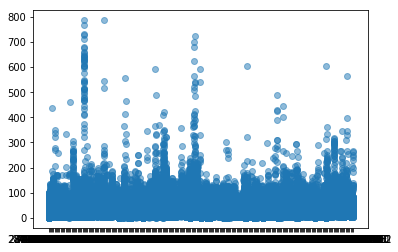

In [88]:
plt.scatter(train_set['device_id'] ,class_train, alpha=0.5)
plt.ylabel('', color='r')
plt.xlabel('', color='r')

In [52]:
class_train = class_train.to_frame()
class_train.columns = ['PM2.5']

In [53]:
train_set.head(5)

,device_id,Date,Time,PM2.5,Temperature,Humidity,lat,lon
0,28C2DDDD415C,2017-01-01,08:03:09,21.0,24.12,83.0,23.741,120.755
1,28C2DDDD415C,2017-01-01,08:03:09,21.0,24.12,83.0,23.741,120.755
2,28C2DDDD415C,2017-01-01,08:03:09,21.0,24.12,83.0,23.741,120.755
3,28C2DDDD415C,2017-01-01,08:09:04,20.0,24.12,82.0,23.741,120.755
4,28C2DDDD415C,2017-01-01,08:09:04,20.0,24.12,82.0,23.741,120.755


In [54]:
class_train.head(10)

,PM2.5
0,21.0
1,21.0
2,21.0
3,20.0
4,20.0
5,20.0
6,20.0
7,20.0
8,20.0
9,22.0


In [55]:
#drop
train_set.drop(['device_id','PM2.5'], axis=1, inplace=True)
test_set.drop(['device_id'], axis=1, inplace=True)
train_set.reset_index(drop=True).head();
test_set.reset_index(drop=True).head();

merge = pd.concat([train_set, test_set], axis=0)
#merge=merge.drop(['Date'],axis=1)
merge.reset_index(drop=True).head();

In [56]:
train_set.head(5)

,Date,Time,Temperature,Humidity,lat,lon
0,2017-01-01,08:03:09,24.12,83.0,23.741,120.755
1,2017-01-01,08:03:09,24.12,83.0,23.741,120.755
2,2017-01-01,08:03:09,24.12,83.0,23.741,120.755
3,2017-01-01,08:09:04,24.12,82.0,23.741,120.755
4,2017-01-01,08:09:04,24.12,82.0,23.741,120.755


In [57]:
merge.head(5)

,Date,Time,Temperature,Humidity,lat,lon
0,2017-01-01,08:03:09,24.12,83.0,23.741,120.755
1,2017-01-01,08:03:09,24.12,83.0,23.741,120.755
2,2017-01-01,08:03:09,24.12,83.0,23.741,120.755
3,2017-01-01,08:09:04,24.12,82.0,23.741,120.755
4,2017-01-01,08:09:04,24.12,82.0,23.741,120.755


In [58]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
new_Time = le.fit_transform(merge.Time)
merge.Time = new_Time
new_Date = le.fit_transform(merge.Date)
merge.Date = new_Date

In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
merge['Time'] = scaler.fit_transform(merge['Time'].values.reshape(-1,1))
merge['Date'] = scaler.fit_transform(merge['Date'].values.reshape(-1,1))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [60]:
merge.head(5)

,Date,Time,Temperature,Humidity,lat,lon
0,0.0,0.335525,24.12,83.0,23.741,120.755
1,0.0,0.335525,24.12,83.0,23.741,120.755
2,0.0,0.335525,24.12,83.0,23.741,120.755
3,0.0,0.339634,24.12,82.0,23.741,120.755
4,0.0,0.339634,24.12,82.0,23.741,120.755


In [61]:
print(merge.shape)

(1157777, 6)


In [62]:
train_set, test_set = np.split(merge,[1116554], axis=0)

In [63]:
train_set.head()

,Date,Time,Temperature,Humidity,lat,lon
0,0.0,0.335525,24.12,83.0,23.741,120.755
1,0.0,0.335525,24.12,83.0,23.741,120.755
2,0.0,0.335525,24.12,83.0,23.741,120.755
3,0.0,0.339634,24.12,82.0,23.741,120.755
4,0.0,0.339634,24.12,82.0,23.741,120.755


In [68]:
#分割 train and validation data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_set, class_train, test_size = 0.1, random_state= 12, shuffle=False)

In [69]:
X_train.head()

,Date,Time,Temperature,Humidity,lat,lon
0,0.0,0.335525,24.12,83.0,23.741,120.755
1,0.0,0.335525,24.12,83.0,23.741,120.755
2,0.0,0.335525,24.12,83.0,23.741,120.755
3,0.0,0.339634,24.12,82.0,23.741,120.755
4,0.0,0.339634,24.12,82.0,23.741,120.755


In [70]:
y_train.head()

,PM2.5
0,21.0
1,21.0
2,21.0
3,20.0
4,20.0


In [75]:
batch_size = 1000
epochs = 100
lr = 0.005
# ------------------------------------graph-----------------------------------------
tf.reset_default_graph() # clean graph
# Declare the input node

with tf.name_scope('input'):
    x_input = tf.placeholder(shape = (None, X_train.shape[1]), name = 'x_input', dtype=tf.float32)
    y_out = tf.placeholder(shape = (None, y_train.shape[1]), name = 'y_label', dtype=tf.float32)

# --------------------Declare the network structure----------------------------
"""---------與上面不一樣的地方(將一個layer的所有程式用一個內建function取代)----------"""
with tf.variable_scope('hidden_layer'):
    x_h1 = tf.layers.dense(inputs= x_input, units= 256, activation=tf.nn.leaky_relu)
    x_h2 = tf.layers.dense(inputs= x_h1, units= 128, activation=tf.nn.leaky_relu)
    x_h3 = tf.layers.dense(inputs= x_h2, units= 64, activation=tf.nn.leaky_relu)
    x_h4 = tf.layers.dense(inputs= x_h3, units= 64, activation=tf.nn.leaky_relu)
    x_h5 = tf.layers.dense(inputs= x_h4, units= 32, activation=tf.nn.leaky_relu)
    #x_h6 = tf.layers.dense(inputs= x_h5, units= 32, activation=tf.nn.relu)
    #x_h7 = tf.layers.dense(inputs= x_h6, units= 16, activation=tf.nn.relu)
    #x_h8 = tf.layers.dense(inputs= x_h7, units= 16, activation=tf.nn.relu)

with tf.variable_scope('output_layer'):
    output = tf.layers.dense(x_h5, y_train.shape[1])
'''---------------------------------------------------------------------------'''
with tf.name_scope('cross_entropy'):
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = output, labels = y_out))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = output, labels = y_out))
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax((output),1), tf.argmax(y_out,1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

100%|██████████| 100/100 [04:26<00:00,  2.67s/it]


--- training done ---
testing accuracy: 1.00


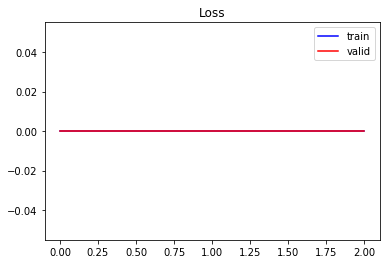

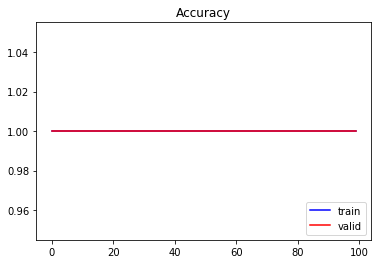

In [76]:
from tqdm import tqdm
train_loss_list, valid_loss_list = [], []
train_acc_list, valid_acc_list = [], []

#-------------------------------------------------------sess-------------------------------------------------------
with tf.Session() as sess:
    # we have to initalize all variables (e.g. weights/biases) at beginning.
    sess.run([tf.global_variables_initializer()])
    # writer = tf.summary.FileWriter("./graph/", sess.graph)
    for i in tqdm(range(epochs)):
        # get batch 
        total_batch = int(np.floor(len(X_train) / batch_size)) 
        # 透過batch size 與資料量計算有幾個batch， just drop out last few samples ...
        
        train_loss_collector, train_acc_collector = [], []
        for j in np.arange(total_batch):
            #-------------------------------取一個batch 的資料-------------------------------------
            batch_idx_start = j * batch_size
            batch_idx_stop = (j+1) * batch_size

            x_batch = X_train[batch_idx_start : batch_idx_stop] 
            y_batch = y_train[batch_idx_start : batch_idx_stop]
            #------------------------------------------------------------------------------------
            this_loss, this_acc, _ = sess.run([loss, compute_acc, train_step], 
                                    feed_dict = {x_input: x_batch, y_out: y_batch})
            # run上一個cell最後三個tensor得到loss值,正確率,和一次優化(得到新的weight 和biases)
            train_loss_collector.append(this_loss) #記錄每個batch的loss
            train_acc_collector.append(this_acc)   #記錄每個batch的acc
            
        # do validation at the end of each epoch(run完一個epoch後，計算一下validation acc 與 validation loss)
        valid_acc, valid_loss = sess.run([compute_acc, loss],
                                         feed_dict = {x_input: X_val,
                                                      y_out : y_val})
        valid_loss_list.append(valid_loss) #記錄validation loss
        valid_acc_list.append(valid_acc)   #記錄validation acc
        train_loss_list.append(np.mean(train_loss_collector)) #記錄每個epoch 平均 loss
        train_acc_list.append(np.mean(train_acc_collector))   #記錄每個epoch 平均 acc

        # at the end of each epoch, shuffle the data 重新排列資料並進入下一個i(epochs)
        X_train, y_train = shuffle(X_train, y_train)
    # At the end of the training, do testing set
    #test_acc, test_loss = sess.run([compute_acc, loss],
                                    #feed_dict = {x_input: x_test,
                                                 #y_out : y_test})
            
#將test data轉乘CSV輸出

    test_pred = sess.run(output, feed_dict={x_input:test_set})
    result = np.argmax(test_pred, axis =1)
    out = list(zip(id_test, result))
    df = pd.DataFrame(data = out, columns=['device_id','pred_pm25'])
    df.to_csv('Result_DNN.csv', index =False, header = True)


print('--- training done ---')
print('testing accuracy: %.2f' % valid_acc_list[-1])
#------------------------------------------------------plot----------------------------------------------------------
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, 'r', label = 'valid')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_acc_list)), valid_acc_list, 'r', label = 'valid')
plt.legend(loc = 4)
plt.title("Accuracy")
plt.show()

In [78]:
df.head()

,device_id,pred_pm25
0,28C2DDDD415C,0
1,28C2DDDD415C,0
2,28C2DDDD415C,0
3,28C2DDDD415C,0
4,28C2DDDD415C,0
